<a href="https://colab.research.google.com/github/suresha97/MSc_Project/blob/main/Spectrograms_Labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Workspace

In [ ]:
#load packages
import scipy
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from IPython import display
from scipy.io import loadmat
import itertools
from itertools import combinations
import math

import pickle 
from scipy import fftpack
import cv2
from astropy.timeseries import LombScargle
from IPython.display import Audio, display
import PIL
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import torch
from torchvision import transforms
from torchvision.transforms import Normalize, Resize, ToTensor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Signal Arrays

In [ ]:
#Make dictionary of singal names and corresponding array index
nums = [x for x in range(1,33,1)]
EEG = ['EEG'+str(x) for x in nums]
peripherals = ['hEOG','vEOG','zEMG','tEMG','GSR','Resp','PPG','Temp']
signal_names = EEG + peripherals
index = [x for x in range(40)]
signal_dict = dict(zip(signal_names, index))

In [ ]:
#Load spectrograms
def get_f(participant):
  with open('/content/drive/My Drive/PHYSIO/data_preprocessed_python/data_preprocessed_python/s{}.dat'.format(participant), 'rb') as f:
      u = pickle._Unpickler(f)
      u.encoding = 'latin1'
      p = u.load()
    
  return np.asarray(p['data'])

all_ppg = []
all_resp = []

ppg_dict = {}
resp_dict = {}

#Save spectrograms for each participant into seperate arrays
for i in np.arange(1,33,1):
  if i < 10:
    part = '0'+str(i)
  else:
    part = str(i)
    
  ppg_dict.update({part : []})
  resp_dict.update({part : []})

  data = get_f(part)

  ppg_ind = signal_dict['PPG']
  resp_ind = signal_dict['Resp']

  all_ppg.append(data[:,ppg_ind])
  all_resp.append(data[:,resp_ind])

all_ppg_array = np.stack(all_ppg)
all_resp_array = np.stack(all_resp)

print(all_ppg_array.shape)
print(all_resp_array.shape)

#Reshape arrays to 32 x 40 = 1280 (total num  samples)
all_ppg_reshape = np.reshape(all_ppg_array, (1280,8064))
all_resp_reshape = np.reshape(all_resp_array, (1280,8064))

print(all_ppg_reshape.shape)
print(all_resp_reshape.shape)

(32, 40, 8064)
(32, 40, 8064)
(1280, 8064)
(1280, 8064)


# Spectrogram Generation

In [ ]:
#Overlapping sliding window
def overlap_windows(data,overlap_rate,window_size):
    window_list = []
    start = 0
    end = window_size
    remain_length = len(data)
    
    while remain_length>=window_size:
        window_list.append(data[int(round(start+0.01)):int(round(end+0.01))])
        start += overlap_rate*window_size #start and end overlap 1
        end += overlap_rate*window_size
        remain_length -= overlap_rate*window_size 
    
    return window_list

#Gaussian window function
def gausswin(L, alpha=2.5):
    N = L - 1
    n = np.arange(0,N+1)-N/2
    w = np.exp(-(1/2)*(alpha*n /(N /2))**2)
    return w


In [ ]:
#single rvs
def rvs_single(Fss,x0):#t0: #7.5

    #Define spectroram parameters
    Tmax = 7.5
    lag = Tmax*Fss #samples per sec x sec'

    #Retreive list of windowed signal segments
    window_list = overlap_windows(x0,0.05,lag) #0.01

    s_PSD_1 = []

    print("Num windows :", len(window_list))

    #Cyclye over each windowed segement of current signal
    for i in range(len(window_list)):

        #Min-max normalise signal data 
        data_use = window_list[i]
        data_info = data_use.copy() #shallow copy

        max_data = max(data_info)
        min_data = min(data_info)
        for j in range(len(data_info)):
            data_info[j] = (data_info[j]-min_data)/(max_data-min_data)

        #Filter paramters
        filterN = 3 
        Wn1=0.8
        Wn2=2.3
        Fn=128/2

        #Band pass filter signal using elliptic filter 
        filter_b, filter_a = scipy.signal.ellip(filterN,3,6,[Wn1/Fn,Wn2/Fn],btype='bandpass')
        filtered_featurescaled_data = scipy.signal.lfilter(filter_b,filter_a,data_info,axis=0)
        w = gausswin(lag) #335

        #Convolve with gaussian
        gaussian_final_window = np.array(filtered_featurescaled_data*w.T,dtype='float64')
    
        #Compute periodogram of signal data
        t = np.arange(0, (len(gaussian_final_window))/Fss, 1/Fss)
        dy = 0.1
        frequency, freq_amplitude = LombScargle(t, gaussian_final_window, dy).autopower(
                                                   samples_per_peak=150)
        #print(frequency.shape)
        #print(freq_amplitude.shape)
        #STACK PSD IN SLIDING WNNDOW
        s_PSD_1.append(freq_amplitude[0:2000])

    s_PSD_1 = np.array(s_PSD_1).T
    ss_PSD_1=s_PSD_1[:,:]

    return ss_PSD_1    

In [ ]:
start_time = time.time()
parts = list(ppg_dict.keys())

#Generate spectrograms for each participant 
count = 0
gen_specs = []

#3, 2:3
#6, 14:15
for sig in all_ppg[0][0:1]:
  print("Generating for Video",count+1,"...")
  spectrogram = rvs_single(128,sig)
  gen_specs.append(spectrogram)
  count += 1

print("Process finished --- %s seconds ---" % ((time.time() - start_time)))

Generating for Video 1 ...
Num windows : 149
Process finished --- 76.23115825653076 seconds ---


In [ ]:
# #Plot signal and corresponging spectrogram
# for j in range(1):

#   plt.figure(figsize=(10,12), dpi= 80, facecolor='w', edgecolor='k')
#   plt.subplot(2,1,1)
#   sig = all_resp[0][j]
#   length = np.arange(0,len(sig),1)
#   plt.plot(length, sig,'r',linewidth = 2)
#   plt.xlabel('Time')
#   plt.ylabel('Amplitude')

#   plt.subplot(2,1,2)
#   spec = gen_specs[j]
#   plt.imshow(spec, origin = 'lower')
#   #[0:700]
#   plt.colorbar()
#   plt.show()
  
# print(spec.shape)

# Spectrogram Resizing

## Original Resize (80 x 80)

In [ ]:
#Set target dimensions for resize 
composed = transforms.Compose([ Resize(size=(120,120)),
                                ToTensor()])

#Resize spectrogram for current participant
spec_list = []
for ppg_spec in gen_specs:
  print(ppg_spec.shape)
  out2 = composed(Image.fromarray(ppg_spec))
  out2 = np.transpose(out2.data.numpy(), (1, 2, 0))
  out2 = out2[:,:,0]
  spec_list.append(out2)

#Save spectrograms in seperate np file for each particiapnt
spec_array = np.stack(spec_list)
np.save('20resp_spec_21.npy', spec_array)

(2000, 149)


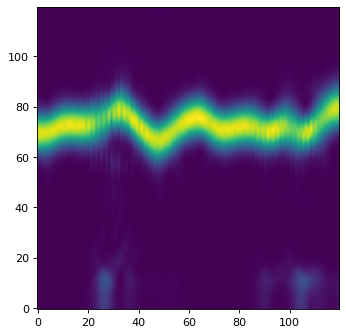

In [ ]:
#View samples of spectograms 
test_spec = np.load('20resp_spec_21.npy')

for i in range(len(test_spec)):
  plt.figure(figsize=(8,5), dpi= 80, facecolor='w', edgecolor='k')
  plt.imshow(test_spec[i],origin='lower')
  plt.show()
  


## Further Resize (40 x 40), (28 x 28)

In [ ]:
#List of strings for each particiapnt number
parts = []
nums = [str(x) for x in range(1,10,1)]
ten = ['0'+x for x in nums]
others = [str(x) for x in range(10,24,1)]
participants = ten+others
print(participants)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']


In [ ]:
composed = transforms.Compose([ Resize(size=(10,10)),
                                ToTensor()])
#Load and resize spectrograms for each participant for both ppg and resp 
for part in participants:
  l_ppg = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/PPG/ppg_spec_{}.npy'.format(part)) #40 x 80 x 80
  l_resp = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/20RESP_new/20resp_spec_{}.npy'.format(part)) #40 x 80 x 80

  ppg_list = []
  resp_list = []
  for i in range(40):

    out_ppg = composed(Image.fromarray(l_ppg[i]))
    out_ppg = np.transpose(out_ppg.data.numpy(), (1, 2, 0))
    out_ppg = out_ppg[:,:,0]
    ppg_list.append(out_ppg)

    out_resp = composed(Image.fromarray(l_resp[i]))
    out_resp = np.transpose(out_resp.data.numpy(), (1, 2, 0))
    out_resp = out_resp[:,:,0]
    resp_list.append(out_resp)

  p_array = np.stack(ppg_list)
  r_array = np.stack(resp_list)

  #Save resized spectrgorams
  np.save('ppg_spec_{}_120.npy'.format(part), p_array)
  np.save('20resp_spec_{}_120.npy'.format(part), r_array)

  #Print samples of resized spectorgrams
  #print("--------------",part,"-------------------")
  #for i in range(2):
  #  plt.imshow(p_array[i],origin='lower')
  #  plt.show()

  #for i in range(2):
  #  plt.imshow(r_array[i],origin='lower')
  #  plt.show()
  

## Orignal (80x80) vs. Resize Comparison

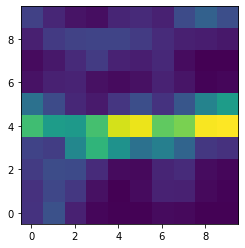

In [ ]:
test80 = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/20RESP_120/20resp_spec_23_120.npy')
test40 = np.load('20resp_spec_23_120.npy')

#Compare two sizes of the same spectrograms
for i in range(40):
  plt.imshow(test80[i],origin='lower')
  #plt.show()
  plt.imshow(test40[i],origin='lower')
  #plt.show()
  #print("--------------------------------")

## Image Resize - OpenCV 


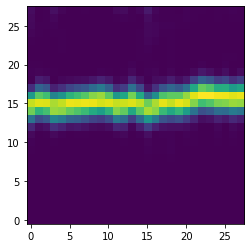

In [ ]:
test_spec = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/PPG/ppg_spec_01.npy')

for i in range(40):
  cv = cv2.resize(test_spec[i], (28,28), interpolation = cv2.INTER_CUBIC)
  plt.imshow(cv, origin='lower')
  #plt.show()

## Image Resize - Pytorch

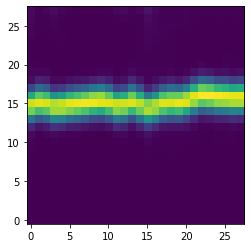

In [ ]:
test_spec = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/PPG/ppg_spec_01.npy')

#Specify size to resize to
composed = transforms.Compose([ Resize(size=(28,28)),
                                ToTensor()])
spec_list = []
#Resize each spec in file
for ppg_spec in test_spec:

  out2 = composed(Image.fromarray(ppg_spec))
  out2 = np.transpose(out2.data.numpy(), (1, 2, 0))
  out2 = out2[:,:,0]
  spec_list.append(out2)

spec_array = np.stack(spec_list)
np.save('ppg_spec_01test', spec_array)

loaded = np.load('ppg_spec_01test.npy')

for i in range(40):
  plt.imshow(loaded[i,:,:], origin = 'lower')
  #plt.show()


# Label Extraction

In [ ]:
#Load all particiapant ratings
def get_f(participant):
  with open('/content/drive/My Drive/PHYSIO/data_preprocessed_python/data_preprocessed_python/s{}.dat'.format(participant), 'rb') as f:
      u = pickle._Unpickler(f)
      u.encoding = 'latin1'
      p = u.load()
    
  return np.asarray(p['labels'])

all_labels = []
#Retreive 40x4 self-reported ratings for all 32 participants 
for part in np.arange(1,33,1):
  if part < 10:
    all_labels.append(get_f('0'+str(part)))
  else:
    all_labels.append(get_f(str(part)))

#Reshape to 32 x 40 x 4
labels_array = np.stack(all_labels)

#Apply min-max normalisation for each rating column for each participant 
scaler = MinMaxScaler()
scaled_labels = []
for i in range(len(labels_array)):
  scaled_labels.append(scaler.fit_transform(labels_array[i]))

#32x40x4 array
scaled_labels = np.stack(scaled_labels)

#Reshape normalised data into 1280 x 4
scaled_reshaped = np.reshape(scaled_labels,(1280,4))

### Manual Thresholding (Binary Classification)

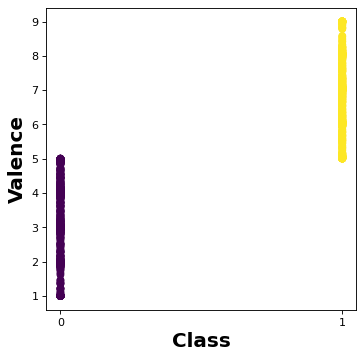

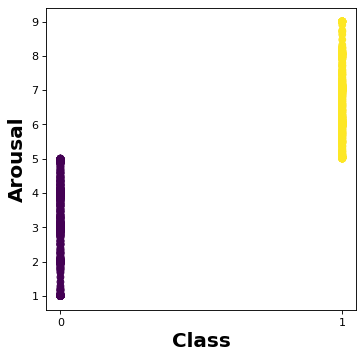

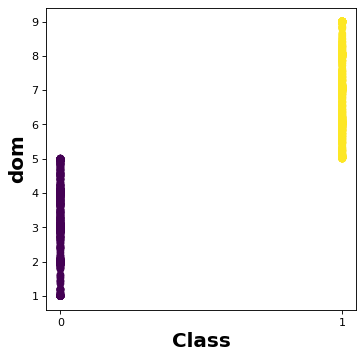

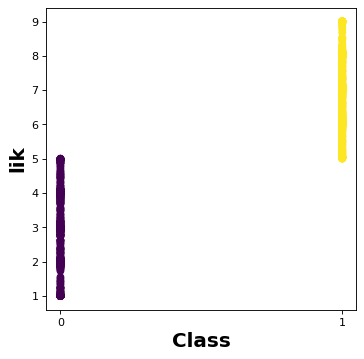

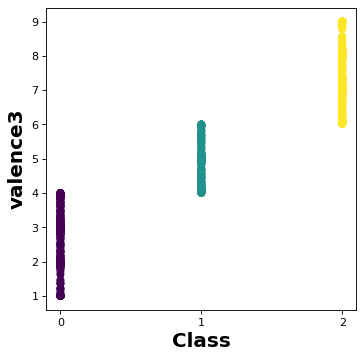

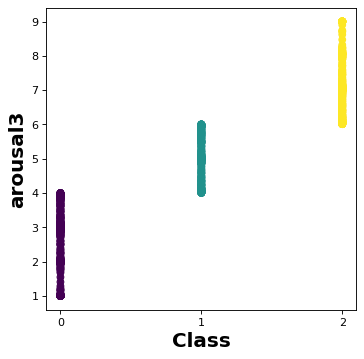

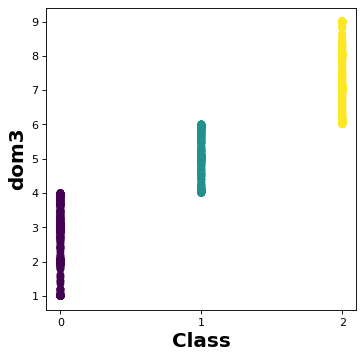

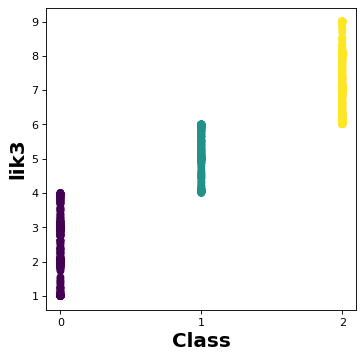

In [ ]:
#Reshape original data into 1280 x 4
original_reshaped = np.reshape(labels_array,(1280,4))

#Seperate arrays for each rating
val = original_reshaped[:,0]
aro = original_reshaped[:,1]
dom = original_reshaped[:,2]
lik = original_reshaped[:,3]

#Create dictionary of values for each clustering of ratings
measures = [val,aro,dom,lik]
df_names = ['Valence','Arousal','dom','lik','valence3','arousal3','dom3','lik3']
val_binary = []
aro_binary = []
dom_binary = []
lik_binary = []

#Empty list for each rating
df_thresh = {}
for i in range(len(df_names)):
  df_thresh[df_names[i]] = []

#Threshold data into 2 clusters [0,1]
for i,arr in enumerate(measures):
  for ele in arr:
    if ele <= 5.0:
      df_thresh[df_names[i]].append(0)
    if ele > 5.0:
      df_thresh[df_names[i]].append(1)

  #print(len(df_thresh[df_names[i]]))

#Threshold data into 3 clusters [0,1,2]
for i,arr in enumerate(measures, 1):
  for ele in arr:
    if ele <= 4.0:
      df_thresh[df_names[3+i]].append(0)
    if ele > 4.0 and ele <= 6.0:
      df_thresh[df_names[3+i]].append(1)
    if ele > 6.0: 
      df_thresh[df_names[3+i]].append(2)

  #print(len(df_thresh[df_names[i]]))

#Cluster each rating type into 2 clusters 
for i,ar in enumerate([val,aro,dom,lik,val,aro,dom,lik]):
  #Cluster data and save
  P = df_thresh[list(df_thresh.keys())[i]]

  #Plot clusters 
  plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
  plt.scatter(P, ar,c=P, marker="o", picker=True)
  plt.ylabel(df_names[i], size = 18, fontweight = 'bold' )
  plt.xlabel('Class', size=18, fontweight = 'bold')
  xint = range(min(P), math.ceil(max(P))+1)
  plt.xticks(xint)
  plt.show()

#Convert dictionary into dataframe and save df to csv file
thresh_df = pd.DataFrame.from_dict(df_thresh)
thresh_df.to_csv('all_labels_threshold.csv',index=False)


## Normalised Manual Thresholding

In [ ]:
#Seperate arrays for each rating
val = scaled_reshaped[:,0]
aro = scaled_reshaped[:,1]
dom = scaled_reshaped[:,2] 
lik = scaled_reshaped[:,3]

#Create dictionary of values for each clustering of ratings
measures = [val,aro,dom,lik]
df_names = ['val','aro','dom','lik']
val_binary = []
aro_binary = []
dom_binary = []
lik_binary = []

#Empty list for each rating
df_thresh = {}
for i in range(4):
  df_thresh[df_names[i]] = []

#Threshold data into 2/3 clusters
for i,arr in enumerate(measures):
  #print(arr[0:10])
  for ele in arr:
    if ele < 0.5:
      df_thresh[df_names[i]].append(0)
    elif ele > 0.5:
      df_thresh[df_names[i]].append(1)
    elif ele == 0.5:
      df_thresh[df_names[i]].append(0)
        
  #print(len(df_thresh[df_names[i]]))

#Convert dictionary into dataframe and save df to csv file
thresh_df = pd.DataFrame.from_dict(df_thresh)
thresh_df.to_csv('threshold_norm.csv',index=False)


## K-means

### 2 Class (K-means)

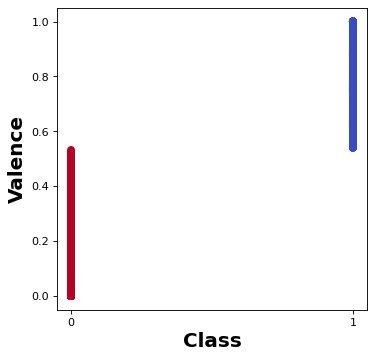

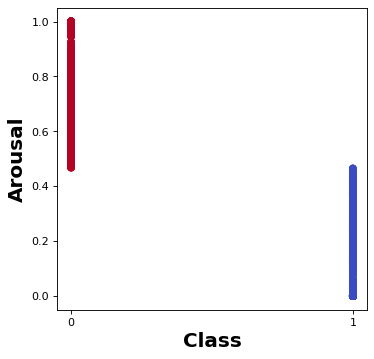

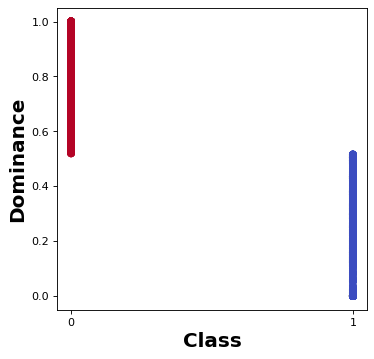

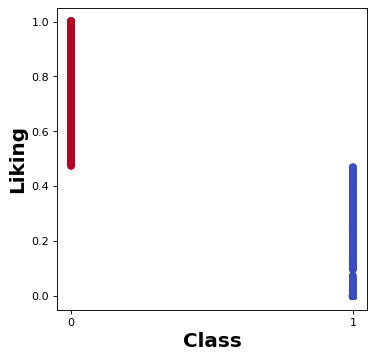

In [ ]:
#Seperate arrays for each rating
val = scaled_reshaped[:,0]
aro = scaled_reshaped[:,1]
dom = scaled_reshaped[:,2]
lik = scaled_reshaped[:,3]

#Dictionary to store K-means clusterd data for each rating type 
two_class = {}
class_strs = ['Valence','Arousal','Dominance','Liking']

#Cluster each rating type into 2 clusters 
for i,ar in enumerate([val,aro,dom,lik]):
  #Cluster data and save
  kmeans = KMeans(n_clusters=2, n_init=10)
  kmeans.fit(ar.reshape(-1,1))
  P = kmeans.predict(ar.reshape(-1,1))
  two_class.update({class_strs[i]:P})
  #print(P)

  #Plot clusters 
  plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
  colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', P))
  plt.scatter(P, ar, c=colors, marker="o", picker=True)
  plt.ylabel(class_strs[i], size = 18, fontweight = 'bold')
  plt.xlabel('Class', size = 18, fontweight = 'bold')
  xint = range(min(P), math.ceil(max(P))+1)
  plt.xticks(xint)
  plt.show()

In [ ]:
#Ensure lw values clusterd with label 0 an high with label 1
# where_0 = np.where(two_class['lik'] == 0)
# where_1 = np.where(two_class['lik'] == 1)

# two_class['lik'][where_0] = 1
# two_class['lik'][where_1] = 0



### 3 Class ((K-means)

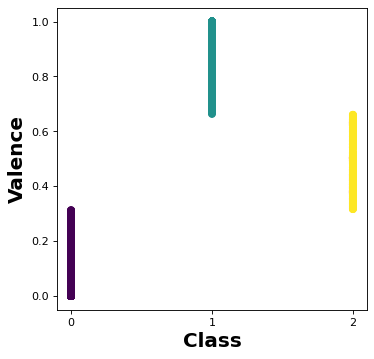

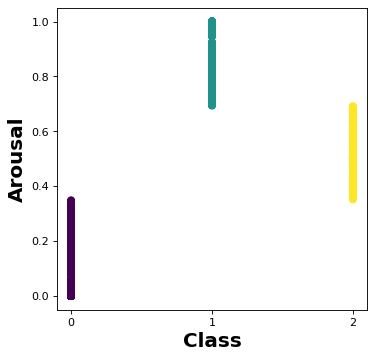

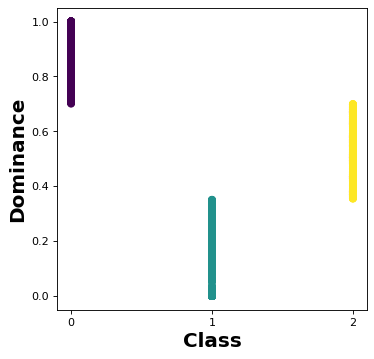

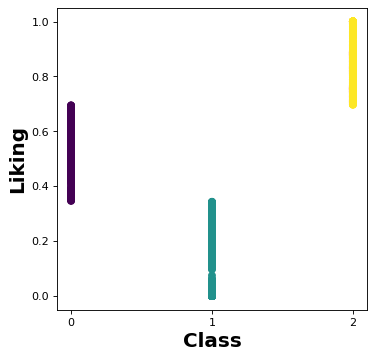

In [ ]:
#Seperate arrays for each rating
val = scaled_reshaped[:,0]
aro = scaled_reshaped[:,1]
dom = scaled_reshaped[:,2]
lik = scaled_reshaped[:,3]

#Dictionary to store K-means clusterd data for each rating type 
cols = ['red','green','blue']
class_strs = ['Valence','Arousal','Dominance','Liking']

#Cluster each rating type into 3 clusters 
for i,ar in enumerate([val, aro, dom, lik]):
  #Cluster data and save
  kmeans = KMeans(n_clusters=3, n_init=10)
  kmeans.fit(ar.reshape(-1,1))
  P = kmeans.predict(ar.reshape(-1,1))
  two_class.update({class_strs[i]:P})
  #print(P)

  #Plot clusters
  plt.figure(figsize=(5,5), dpi= 80, facecolor='w')
  #colors = list(map(lambda x: '#3b4cc0' if x == 0 '#3b4cc0' if x ==1  else '#b40426', P))
  plt.scatter(P, ar,c=P, marker="o", picker=True)
  plt.ylabel(class_strs[i], size = 18, fontweight = 'bold' )
  plt.xlabel('Class', size=18, fontweight = 'bold')
  xint = range(min(P), math.ceil(max(P))+1)
  plt.xticks(xint)
  plt.show()
  #3b4cc0

In [ ]:
#Ensure labels are 0,1 and 2 for low, medium and high clusters respectively
where_0 = np.where(two_class['val3'] == 0)
where_1 = np.where(two_class['val3'] == 1)
where_2 = np.where(two_class['val3'] == 2)

two_class['val3'][where_0] = 2
two_class['val3'][where_1] = 0
two_class['val3'][where_2] = 1


where_0 = np.where(two_class['aro3'] == 0)
where_1 = np.where(two_class['aro3'] == 1)
where_2 = np.where(two_class['aro3'] == 2)

two_class['aro3'][where_0] = 2
two_class['aro3'][where_1] = 0
two_class['aro3'][where_2] = 1

where_0 = np.where(two_class['dom3'] == 0)
where_1 = np.where(two_class['dom3'] == 1)
where_2 = np.where(two_class['dom3'] == 2)

two_class['dom3'][where_0] = 1
two_class['dom3'][where_1] = 2
two_class['dom3'][where_2] = 0

where_0 = np.where(two_class['lik3'] == 0)
where_1 = np.where(two_class['lik3'] == 1)
where_2 = np.where(two_class['lik3'] == 2)

two_class['lik3'][where_0] = 1
two_class['lik3'][where_1] = 0



### 4 Class (K-means)

No handles with labels found to put in legend.


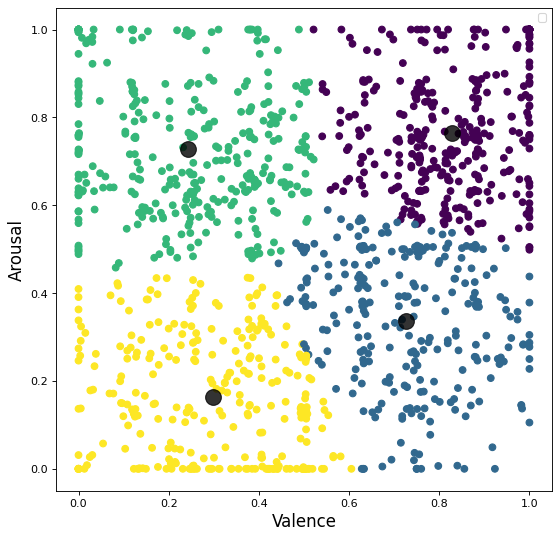

In [ ]:
#Retrieve valence and arousal for each participant as 2D array
labels_array_reshaped = np.reshape(labels_array,(1280,4))
val_aro = scaled_reshaped[:,0:2]
val_aro2 = labels_array_reshaped[:,0:2]

#Custer samples into 4 clusters using valence and arousal as feautures
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(val_aro)
P = kmeans.predict(val_aro)
C = kmeans.cluster_centers_
#print(C)
#print(P[0:20])

#Plot clusters 
plt.figure(figsize=(8,8), dpi= 80, facecolor='w', edgecolor='k')
colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', P))
plt.scatter(val_aro[:,0], val_aro[:,1],cmap = 'viridis',c = P, marker="o", picker=True)
plt.scatter(C[:,0], C[:,1],c = 'black', s=200, alpha =0.8)
plt.xlabel('Valence', size = 15)
plt.ylabel('Arousal', size = 15)
plt.legend()
plt.show()


In [ ]:
#Update class labels with circumplex model quadrant names 
all_clusters = []
new_labels = {}
for i in range(4):
  cluster_i = [x for x in P if x==i]

  if C[i][0] > 0.5 and C[i][1] > 0.5:
    new_labels.update({i:'HVHA'})
  if C[i][0] > 0.5 and C[i][1] < 0.5:
    new_labels.update({i:'HVLA'})
  if C[i][0] < 0.5 and C[i][1] > 0.5:
    new_labels.update({i:'LVHA'})
  if C[i][0] < 0.5 and C[i][1] < 0.5:
    new_labels.update({i:'LVLA'})

class_labels_4 = []
for i in range(len(P)):
  class_labels_4.append(new_labels[P[i]])
print()


In [ ]:
#Add 4 cluster K-means to 2 and 3 cluster k-means
print(list(two_class.keys()))
two_class['class_4'] = class_labels_4
print(list(two_class.keys()))

#Convert dict to pd and save pd to csv file
test_dict = pd.DataFrame.from_dict(two_class)
test_dict.to_csv('all_labels.csv',index=False)

['Valence', 'Arousal', 'Dominance', 'Liking']
['Valence', 'Arousal', 'Dominance', 'Liking', 'class_4']


# Visualise Spectrograms by Class

In [ ]:

#Load spectorgram data into seperate lists for each signal
parts = []
nums = [str(x) for x in range(1,10,1)]
ten = ['0'+x for x in nums]
others = [str(x) for x in range(10,24,1)]
participants = ten+others

ppg_full_list = [] 
resp_full_list = []
for part in participants: 
  l_ppg = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/PPG_120/ppg_spec_{}_120.npy'.format(part)) 
  l_resp = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/RESP_120/resp_spec_{}_120.npy'.format(part)) 

  ppg_full_list.append(l_ppg)
  resp_full_list.append(l_resp)


In [ ]:
#Flatten spectrgrams lists into arrays
print(len(ppg_full_list))
ppg_full_array = np.vstack(ppg_full_list)
print(ppg_full_array.shape)

print(len(resp_full_list))
resp_full_array = np.vstack(resp_full_list)
print(resp_full_array.shape)

23
(920, 120, 120)
23
(920, 120, 120)


In [ ]:
HVHA = []
HVLA = []
LVHA = []
LVLA = []

#Find samples of spectrograms in the extremes of each quadrant
for i in range(1280):
  if scaled_reshaped[i][0] > 0.75 and scaled_reshaped[i][1] > 0.75:
    HVHA.append(i)
  if scaled_reshaped[i][0] > 0.75 and scaled_reshaped[i][1] < 0.25:
    HVLA.append(i)
  if scaled_reshaped[i][0] < 0.25 and scaled_reshaped[i][1] > 0.75:
    LVHA.append(i)
  if scaled_reshaped[i][0] < 0.25 and scaled_reshaped[i][1] < 0.25:
    LVLA.append(i)

In [ ]:

#print samples of each cluster quadrant
print("HVHA:",HVHA[0:10])
print("LVHA:",LVHA[0:10])
print("HVLA",HVLA[0:10])
print("LVLA",LVLA[0:10])

val_inds = np.where(scaled_reshaped[:,0] < 0.1)
print(val_inds[0])

HVHA: [0, 1, 2, 17, 18, 19, 20, 24, 25, 26]
LVHA: [14, 16, 30, 31, 33, 34, 35, 36, 68, 69]
HVLA [7, 22, 50, 97, 185, 207, 211, 221, 252, 254]
LVLA [10, 11, 12, 28, 29, 60, 62, 74, 78, 102]
[   9   12   28   29   34   60   62   71   76   77   78  102  103  104
  114  140  151  152  156  157  182  197  198  222  223  230  233  263
  265  267  309  310  315  347  351  352  354  355  356  357  358  384
  394  397  434  436  437  438  468  474  476  502  514  516  517  540
  549  583  589  597  616  632  633  634  661  669  675  676  703  709
  740  744  757  782  783  784  788  796  819  821  869  876  877  878
  900  942  949  969  988  990  991  996  997  998  999 1032 1033 1036
 1037 1074 1077 1114 1116 1118 1147 1150 1180 1182 1198 1222 1231 1236
 1237 1238 1263 1269]


In [ ]:
#Find exmpales of spectorgrams found win low, mid and high clusters for val and arousal
print("HVHA:",HVHA[0:20])
print("LVHA:",LVHA[0:20])
print("HVLA:",HVLA[0:20])
print("LVLA:",LVLA[0:20])

val_inds0 = np.where(scaled_reshaped[:,0] < 0.1)
val_inds1 = np.where(scaled_reshaped[:,0] == 0.5)
val_inds2 = np.where(scaled_reshaped[:,0] > 0.9)

print("Valence")
print(val_inds0[0][0:10])
print(val_inds1[0][0:10])
print(val_inds2[0][0:10])

print()
aro_inds0 = np.where(scaled_reshaped[:,1] < 0.1)
aro_inds1 = np.where(scaled_reshaped[:,1] == 0.5)
aro_inds2 = np.where(scaled_reshaped[:,1] > 0.9)

print("Arousal")
print(aro_inds0[0][0:10])
print(aro_inds1[0][0:10])
print(aro_inds2[0][0:10])


HVHA: [0, 1, 2, 17, 18, 19, 20, 24, 25, 26, 41, 42, 47, 53, 54, 58, 59, 63, 64, 65]
LVHA: [14, 16, 30, 31, 33, 34, 35, 36, 68, 69, 71, 76, 77, 147, 189, 315, 347, 355, 395, 396]
HVLA: [7, 22, 50, 97, 185, 207, 211, 221, 252, 254, 256, 257, 268, 297, 410, 412, 414, 531, 532, 534]
LVLA: [10, 11, 12, 28, 29, 60, 62, 74, 78, 102, 103, 104, 126, 140, 142, 150, 152, 153, 155, 156]
Valence
[ 9 12 28 29 34 60 62 71 76 77]
[  45   61   72  495  854  865  963  965 1223 1226]
[ 2  5 19 20 24 40 42 47 48 52]

Arousal
[ 7 10 13 21 28 43 49 50 60 61]
[ 888  890  905  946 1088 1116 1127 1156 1230]
[ 0 14 18 19 20 30 31 34 42 47]


## PPG

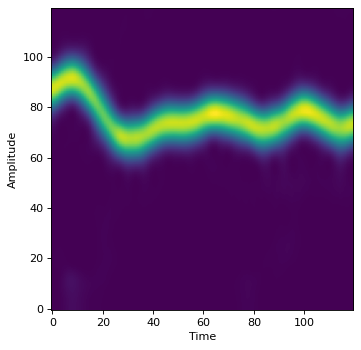

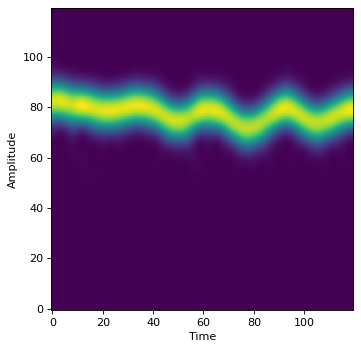

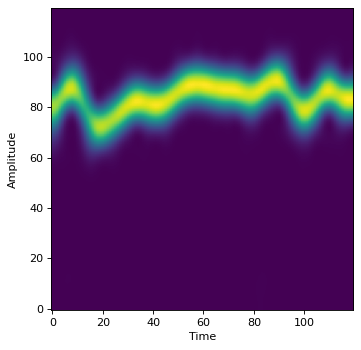

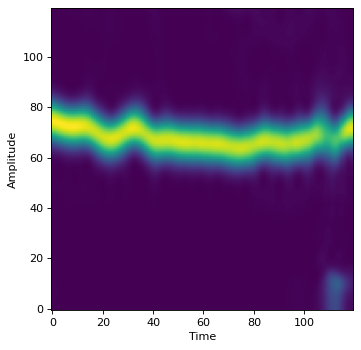

In [ ]:
#
#2  14  6  10

#64
plt.figure(figsize=(8,5), dpi= 80, facecolor='w', edgecolor='k')
#plt.title('HVHA',size = 15)
plt.imshow(ppg_full_array[64], origin = 'lower')
#length = np.arange(0,len(all_ppg_reshape[122]),1)
#plt.plot(length, all_ppg_reshape[64],'r',linewidth = 2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


#71
plt.figure(figsize=(8,5), dpi= 80, facecolor='w', edgecolor='k')
#plt.title('LVHA',size = 15)
plt.imshow(ppg_full_array[71], origin = 'lower')
#length = np.arange(0,len(all_ppg_reshape[71]),1)
#plt.plot(length, all_ppg_reshape[71],'r',linewidth = 2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()


#221
plt.figure(figsize=(8,5), dpi= 80, facecolor='w', edgecolor='k')
#plt.title('HVLA',size = 15)
plt.imshow(ppg_full_array[254], origin = 'lower')
#length = np.arange(0,len(all_resp_reshape[254]),1)
#plt.plot(length, all_ppg_reshape[254],'r',linewidth = 2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

plt.show()

#10
plt.figure(figsize=(8,5), dpi= 80, facecolor='w', edgecolor='k')
#plt.title('LVLA',size = 15)
plt.imshow(ppg_full_array[10], origin = 'lower')
#length = np.arange(0,len(all_resp_reshape[254]),1)
#plt.plot(length, all_ppg_reshape[10],'r',linewidth = 2)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

plt.show()

## RESP

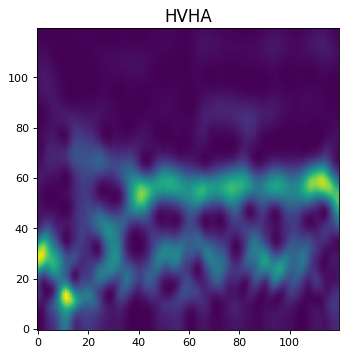

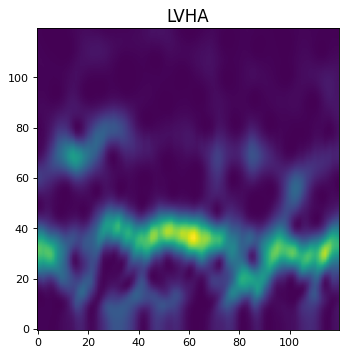

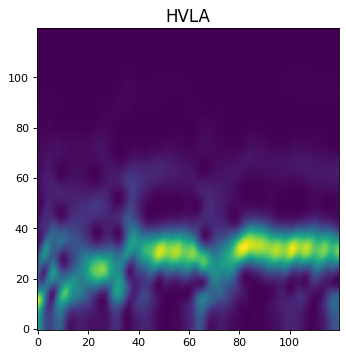

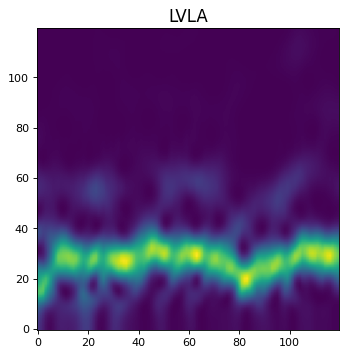

In [ ]:
'''
for ind in val_inds2[0][0:5]:
  plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
  plt.title('Low')
  plt.imshow(resp_full_array[val_inds2[0][ind]], origin = 'lower')
  plt.show()

plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Medium')
plt.imshow(resp_full_array[880], origin = 'lower')
plt.show()

plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
plt.title('High')
plt.imshow(resp_full_array[42], origin = 'lower')
plt.show()

l_resp = resp_full_array[122]
out_resp = composed(Image.fromarray(l_resp))
out_resp = np.transpose(out_resp.data.numpy(), (1, 2, 0))
out_resp = out_resp[:,:,0]
resp_list.append(out_resp)
'''
#122
#139
plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
plt.title('HVHA',size = 15)
plt.imshow(resp_full_array[122], origin = 'lower')
plt.show()

#355
#77
plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
plt.title('LVHA',size = 15)
plt.imshow(resp_full_array[355], origin = 'lower')
plt.show()

#185
#412
plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
plt.title('HVLA',size = 15)
plt.imshow(resp_full_array[50], origin = 'lower')
plt.show()


#28
plt.figure(figsize=(5,5), dpi= 80, facecolor='w', edgecolor='k')
plt.title('LVLA',size = 15)
plt.imshow(resp_full_array[28], origin = 'lower')
plt.show()


# Alpha-Blending

In [ ]:
alpha_comb = []
blended = []

#For each sample
for i in range(len(ppg_full_array)):
  #print(i)
  test_ppg = ppg_full_array[i]
  test_resp = resp_full_array[i]

  #axes_img = plt.imshow(test_ppg, origin = 'lower')
  #axes_img2 = plt.imshow(test_resp, origin = 'lower')

  #Plot spectrogram of ppg and resp seperately 
  #plt.imshow(axes_img.get_array(), origin = 'lower')
  #plt.show()
  #plt.imshow(axes_img2.get_array(), origin = 'lower')
  #plt.show()

  #Scale arrays 
  scaled_img = (axes_img.get_array()-axes_img.get_clim()[0])/(axes_img.get_clim()[1]-axes_img.get_clim()[0])
  scaled_img2 = (axes_img2.get_array()-axes_img2.get_clim()[0])/(axes_img2.get_clim()[1]-axes_img2.get_clim()[0])

  #Conversion to singal channel image
  heatmap_image = Image.fromarray(np.uint8(axes_img.get_cmap()(scaled_img) * 255)).convert('LA')
  heatmap_image2 = Image.fromarray(np.uint8(axes_img2.get_cmap()(scaled_img2) * 255)).convert('LA')

  #Alpha blend images with .5 transaprency
  alphaBlended2 = Image.blend(heatmap_image, heatmap_image2, alpha=.5)
  np_im = np.array(alphaBlended2)

  #Plot blended spectogram
  #axes_img3 = plt.imshow(np.array(np_im)[:,:,0], origin = 'lower')
  #plt.show()
  blended.append(np.array(np_im)[:,:,0])
  #print("------------------------------------------------------------")

#Save blended spectrograms
blended_array = np.asarray(blended)
#print(blended_array.shape)
np.save('spec_alpha_blend.npy', blended_array)

# Testing Spectorgrams and Corresponding Labels
- Print corresponding arousal and valence value
- CHECK EACH PARTICIPANT TO SEE IF RANGE FITS ALL
- CHECK IF LABELS OF FIRST AND LAST PARTICIPANT VIDESO MATCH UP TO CURRENT

In [ ]:
#List of strings for each particiapnt
parts = []
nums = [str(x) for x in range(1,10,1)]
ten = ['0'+x for x in nums]
others = [str(x) for x in range(10,24,1)]
participants = ten+others

ppg_full_list = [] # 32 elements of 40 x 80 x 80 arrays
resp_full_list = []
resp_full_list2 = []


#Load spectorgrams of PPG and RESP signals for each particiapnt
for part in participants: 
  l_ppg = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/PPG_120/ppg_spec_{}_120.npy'.format(part)) #40 x 80 x 80
  l_resp = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/RESP_120/resp_spec_{}_120.npy'.format(part)) #40 x 80 x 80 
  l_resp2 = np.load('/content/drive/My Drive/PHYSIO/Generated_Specs/20RESP_new/20resp_spec_{}.npy'.format(part)) #40 x 80 x 80 


  ppg_full_list.append(l_ppg)
  resp_full_list.append(l_resp)
  resp_full_list2.append(l_resp2)

  

print(len(ppg_full_list))
ppg_full_array = np.vstack(ppg_full_list)
print(ppg_full_array.shape)

print(len(resp_full_list))
resp_full_array = np.vstack(resp_full_list)
print(resp_full_array.shape)

print(len(resp_full_list2))
resp_full_array2 = np.vstack(resp_full_list2)
print(resp_full_array2.shape)


23
(920, 120, 120)
23
(920, 120, 120)
23
(920, 80, 80)


In [ ]:
labels_tdf = pd.read_csv("/content/drive/My Drive/PHYSIO/Generated_Specs/all_labels_threshold_5.0.csv") 
labels_tdf.head()

,val,aro,dom,lik,val3,aro3,dom3,lik3
0,1,1,1,1,2,2,2,2
1,1,1,1,1,2,2,2,2
2,1,1,1,1,2,2,2,2
3,0,1,1,1,1,2,2,2
4,1,0,1,1,2,0,2,2


In [ ]:
labs_part = np.split(labels_tdf.to_numpy()[0:920], 23)
print(labs_part[0].shape)


(40, 8)


In [ ]:


part = 18

def get_f(participant):
  with open('/content/drive/My Drive/PHYSIO/data_preprocessed_python/data_preprocessed_python/s{}.dat'.format(participant), 'rb') as f:
      u = pickle._Unpickler(f)
      u.encoding = 'latin1'
      p = u.load()
    
  return np.asarray(p['labels']), np.asarray(p['data'])

labs, feats = get_f('18')
l_class = labs_part[17]

for i,spec in enumerate(resp_full_list[part-1]):
  print("Valence:", labs[i,0],"Class :",l_class[i,0], "Arousal:", labs[i,1], "Class :", l_class[i,1])
  
  plt.figure(figsize=(33,8), dpi= 80, facecolor='w', edgecolor='k')
  plt.subplot(1,3,1)
  sig = feats[i,signal_dict['Resp']]
  length = np.arange(0,len(sig),1)
  plt.plot(length, sig,'r',linewidth = 2)
  plt.xlabel('Time')
  plt.ylabel('Amplitude')

  plt.subplot(1,3,2)
  plt.imshow(spec, origin = 'lower')
  plt.colorbar()

  plt.subplot(1,3,3)
  plt.imshow(resp_full_list2[part-1][i], origin = 'lower')
  plt.colorbar()
  plt.show()
  print("------------------------------------------------")
  